In [28]:
from nltk.tokenize import word_tokenize
from graphviz import Digraph
from pprint import pprint
from pulp import *
from time import sleep
import math
import copy
import json

In [51]:
sample = """
t1=LOAD(x);
t2=t1 +4;
t3=t1 *8;
t4=t1 -4;
t5=t1 /2;
t6=t2 * t3;
t7=t4-t5;
t8=t6 * t7;
t9=t5 * t2;
t10= ^ t9;
STORE(y , t8 );
STORE(z , t10 );"""


In [ ]:
sample = """
t1=LOAD(x);
t2=t1 +4;
t3= t1 * 8;
t4=t3 /t2;
STORE(y , t4 );"""

In [54]:
sample = """
t1=LOAD(x);
t2=t1 + t1;
t1=t1 - 4;
t2=t1 /t2;
t1=t2 * t1;
STORE(y , t1 );
STORE(z , t2 );
"""

In [58]:
sample = """
t1=LOAD(x);
t1=t1*t1;
t2=t1 * t1;
t2=t1 + 4;
STORE(y , t2 );"""

[('LOAD', 't1', 'x', ()),
 ('MUL', 't1', 't1', 't1', (0,)),
 ('MUL', 't2', 't1', 't1', (1,)),
 ('ADD', 't2', 't1', '4', (1,)),
 ('STORE', 'y', 't2', (3,))]
ind ['t1', 't1', 't2', 't2', 'y']
dep [[], ['t1'], ['t1'], ['t1'], ['t2']]
line: [(), (0,), (1,), (1,), (3,)]


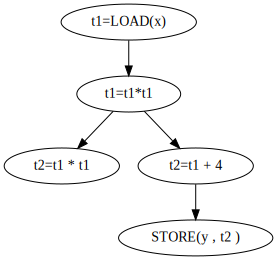

In [59]:
class Parser():
    def __init__(self) -> None:
        self.keywords = ["if", "LOAD", "STORE", "="]
        self.operators = ["*","/","+","-"]
        self.delims = [" ", "(",")","="]
        self.symbol_to_name = { "+": "ADD",
                                "-": "SUB",
                                "*": "MUL",
                                "/": "DIV",
                                "^": "SQRT" }
        self.dot = Digraph()
    
    def _gen_tokenized_list(self,instructions):
        tokenized_list = []
        for instr in instructions[:]:
            tokens = []
            cur = ""
            pos = 0
            while pos < len(instr):
                if instr[pos] in self.delims or instr[pos] in self.operators:
                    if cur != "":
                        tokens.append(cur)
                    if instr[pos] != " ":
                        tokens.append(instr[pos])
                    cur = ""
                else:
                    cur += instr[pos]
                pos += 1
            if cur != "":
                tokens.append(cur)
            tokenized_list.append(tokens)
        return tokenized_list

    def _gen_dependencies(self,IR):
        writes, reads = [], []
        write_depend, edges = [], []
        read_depend = []

        for instr in IR:
            depend_tokens = []
            depend_tokens_pos = []
            #Check Read Dependicies
            #print(instr)
            for token in  instr[2:]:
                #print(token,instr[2:],indep)  
                for pos, dep_token in reversed(list(enumerate(writes))):
                    if token == dep_token:
                        if token not in depend_tokens: 
                            depend_tokens.append(token)
                            depend_tokens_pos.append(pos)
                        break
                    
            #Check Write Dependicies
            token = instr[1]
            read_tokens = []
            read_tokens_pos = []
            for pos , tokens in  enumerate(reads):
                if token in tokens:
                    read_tokens.append(token)
                    read_tokens_pos.append(pos)


            read_depend.append(tuple(set(read_tokens_pos)))
            writes.append('' if instr[1] == "STORE" else instr[1])
  
            reads.append(depend_tokens)
            write_depend.append(tuple(set(depend_tokens_pos)))

        for x, ys in enumerate(write_depend):
            for y in ys:
                edges.append((y,x))

        for idx in range(len(IR)):
            all_depend = tuple(set((write_depend[idx]+read_depend[idx])))
            IR[idx] = IR[idx] +tuple((all_depend, ))
        
        return writes, reads, edges, write_depend

    def _dfg(self,instructions,edges):
        file_contents = ""
        for idx, instr in enumerate(instructions):
            self.dot.node(str(idx), instr)
            file_contents += f"{idx}: {instr}\n"

        for x,y in edges:
            self.dot.edge(str(x),str(y))
            file_contents += f"{x}->{y}\n"
        
        with open("DFG.output", "w") as f:
            f.write(file_contents)

    def _gen_IR(self, tokenized_list):
        IR = []
        for tokens in tokenized_list:
            if "LOAD" in tokens:
                IR.append(("LOAD",tokens[0],tokens[4]))
            elif "=" in tokens:
                if tokens[2] != "^":
                    IR.append((self.symbol_to_name[tokens[3]],tokens[0],tokens[2],tokens[4]))
                else:
                    IR.append((self.symbol_to_name[tokens[2]],tokens[0],tokens[3]))
            elif "STORE" in tokens:
                IR.append(("STORE",tokens[2],tokens[4]))
        
        return IR 

    def parse(self,code):
    
        instructions = [instr.strip("\n") for instr in code.split(";")[:-1]]
        
        tokenized_list = self._gen_tokenized_list(instructions)

        self.IR = self._gen_IR(tokenized_list)
        
        self.indep, self.depend, edges, self.line_depend = self._gen_dependencies(self.IR)
        
        self._dfg(instructions,edges)

        
        return self.IR,self.depend,self.indep,self.line_depend

parse_instance = Parser()
IR,depend,indep,line_depend= parse_instance.parse(sample)
pprint(IR)
print("ind",indep)
print("dep",depend)
print("line:",line_depend)

parse_instance.dot
        

In [38]:

class CodeGen():
    def __init__(self,num_PEs,path="/") -> None:
        self.file_path = path
        self.num_PEs = num_PEs
        with open('operation_latency.json', 'r') as f:
            self.cycle_times = json.load(f)
    
    def generate_backend_code(self,IR):
        # Step 2: Receive IR, number of PEs, and cycle times

        # Step 3: Assign initial tasks to PEs
        assignments = self.initial_assignment(IR)
        
        #Step 4:
        execution_times = self.calculate_execution_times(assignments)

        # Step 5: Check workload imbalance
        max_execution_time = max(execution_times)
        min_execution_time = min(execution_times)
        cur_imbalance = max_execution_time - min_execution_time


      
        iteration = 0

        #Repeat 4-6
        while True:
            
            
            # Step 6: Task migration or swapping strategy
            new_assignments = self.rebalance_workload(assignments, execution_times)

            # Step 4: Calculate execution cost for each PE
            execution_times = self.calculate_execution_times(new_assignments)

            # Step 5: Check workload imbalance
            max_execution_time = max(execution_times)
            min_execution_time = min(execution_times)
            new_imbalance = max_execution_time - min_execution_time

            print(f"Iteration: {iteration}\t New Imbalance: {new_imbalance}, Current Imbalance: {cur_imbalance}")
            if new_imbalance >= cur_imbalance or cur_imbalance==0:
                print(f"Stopping with an Current Imbalance of {cur_imbalance}")
                
                break  # Terminate if workload is balanced within threshold or maximum iterations reached
            cur_imbalance = new_imbalance
            assignments = new_assignments
            
            iteration += 1 
        synced_tasks = self.sync(assignments, IR)
        for pe_id, assigned_tasks in enumerate(synced_tasks):
            # Step 8: Generate output code for each PE
            code = self.generate_code(assigned_tasks)

            # Step 9: Dump output code to files
            self.dump_code_to_file(code, pe_id)

    def initial_assignment(self,tasks):
        # Assign initial tasks to PEs
        
        assignments = [[] for _ in range(self.num_PEs)]
        task_index = 0

        for task in tasks:
            pe_id = task_index % self.num_PEs
            assignments[pe_id].append(task)
            task_index += 1

        
        return assignments

    def calculate_execution_times(self,assignments):
        # Calculate execution time for each PE
        execution_times = []

        for assigned_tasks in assignments:
            execution_time = 0
            for task in assigned_tasks:
                if task:
                    task_name = task[0]
                    if task_name in self.cycle_times:
                        execution_time += self.cycle_times[task_name]
            execution_times.append(execution_time)

        return execution_times

    def rebalance_workload(self,assignments, execution_times):

        new_assignments = copy.deepcopy(assignments)
        
        # Perform task migration or swapping to balance workload
        max_index = execution_times.index(max(execution_times))
        min_index = execution_times.index(min(execution_times))

        # Swap a task from the most loaded PE to the least loaded PE
        task_to_swap = new_assignments[max_index].pop(0)
        new_assignments[min_index].append(task_to_swap)

        return new_assignments

    def sync(self,assignments, IR):

        sync_code = [[] for _ in range(len(assignments))]
        hash = {}
        instruction_cycle_times = [self.cycle_times[task[0]] for task in IR]
        for pos, instruc in enumerate(IR):
            hash[instruc] = pos
            

        live_time = [0 for _ in range(len(assignments)) ]
        current_instruction = ["NOP"for _ in range(len(assignments)) ]
        numerical_assignment = [[(hash[task],task[-1]) for task in tasks] for tasks in assignments ]

        instructions_done = set()
        instructions_done.add(None)
        cycle = 1
        while len(IR) != len(instructions_done)-1:

            for idx, (current, count) in enumerate(zip(current_instruction,live_time)):
                #print(idx, current, count)
                if current != "NOP":
                    if count <= 1:
                        instructions_done.add(current)
                        current_instruction[idx] = "NOP"
                    live_time[idx] -= 1

            for assignment_id, tasks in enumerate(numerical_assignment):
                
                if current_instruction[assignment_id] == "NOP":
                    for task in tasks:
                        #print(assignment_id, task, type(task[1]), task[0] not in instructions_done and task[1] in instructions_done)
                        if task[0] not in instructions_done and all(num in instructions_done for num in task[1]):
                            #print("Added ",task[0])
                            current_instruction[assignment_id] = task[0]  
                            live_time[assignment_id] = instruction_cycle_times[task[0]]
                            sync_code[assignment_id].append(IR[task[0]])
                            break

                if current_instruction[assignment_id] == "NOP" and len(IR) != len(instructions_done)-1:
                    sync_code[assignment_id].append("NOP")

            """ print(f'Cycle {cycle}')
            print(instructions_done)
            print(current_instruction)
            print(live_time)
            print() """

            cycle += 1
            #sleep(1)
        #pprint(sync_code)
        return  sync_code 
            
    def generate_code(self,tasks):
        # Generate output code for a given set of tasks
        code = ""
        self.cycle_times['N'] = 1
        #print("final tasks:",tasks)
        for task in tasks:
            if task:
                #print(task)
                for idx in range(self.cycle_times[task[0]]):
                        task_formated = str(task[:len(task)-1]).strip("()").replace("'", "") if task != "NOP" else task
                        code += (task_formated + "\n")  if idx == 0 else "\n"

        return code

    def dump_code_to_file(self,code, pe_id):
        # Dump generated code to a file for a specific PE
        filename = f"{self.file_path}PE_{pe_id}_code.txt"

        with open(filename, "w") as file:
            file.write(code)

multi_core_count = 3   

multi_code_gen_instance = CodeGen(multi_core_count,path="multi-core_code/")
multi_code_gen_instance.generate_backend_code(IR)

single_code_gen_instance = CodeGen(1,path="single-core_code/")
single_code_gen_instance.generate_backend_code(IR)

Iteration: 0	 New Imbalance: 6, Current Imbalance: 8
Iteration: 1	 New Imbalance: 10, Current Imbalance: 6
Stopping with an Current Imbalance of 6
Iteration: 0	 New Imbalance: 0, Current Imbalance: 0
Stopping with an Current Imbalance of 0


In [39]:
class Simulator():
    def __init__(self, pes, file_path) -> None:
        self.MEM = {}
        self.RG = {}
        self.pe_count = pes
        self.file_path = file_path
        with open('operation_latency.json', 'r') as f:
            self.cycle_times = json.load(f)
        self.cycle_times['NOP'] = 1
    
    def load_files(self):
        code = []
        for pe in range(self.pe_count):
            file_name = f'PE_{pe}_code.txt'
            with open(self.file_path+file_name) as f:
                data = f.read()
            code.append([[j.replace(" ",'') for j in i.split(",")]for i in data.split("\n") if i])
        print(code)
        return code

    def run(self):
        code = self.load_files()
        instruction_running = ["NOP"]*self.pe_count
        live_cycles = [0]*self.pe_count
        instruction_pos = [0]*self.pe_count
        cycle = 1
        while all((instruction_pos[pe] < len(code[pe])) for pe in range(self.pe_count)):
            
            for pe in range(self.pe_count):

                pos = instruction_pos[pe]
                if pos >= len(code[pe]):
                    continue

                #Cycle over. Update with New instruction
                if live_cycles[pe] == 0:
                    instruction_running[pe] = code[pe][pos]
                    live_cycles[pe] = self.cycle_times[instruction_running[pe][0]]
                    instruction_pos[pe] += 1
                    self.execute(instruction_running[pe])
            
            
            #sleep(1)
            message = ""
            message += f'Cycle:{cycle},'
            for pe in range(self.pe_count):
                message += f"\tPE_{pe}: {', '.join(instruction_running[pe])}[{live_cycles[pe]}], "
            #message += f'\n\t\tRG:{self.RG}  \tMEM:{self.MEM}'
            print(message)

            #Update cycle times
            for pe in range(self.pe_count):
                live_cycles[pe] -= 1

            #print(cycle,instruction_running,live_cycles,instruction_pos)
            cycle += 1
 
    def execute(self, instruction):
        instruction_name = instruction[0]
        
        if instruction_name == "LOAD":
            if instruction[2] not in self.MEM:
                raise(ValueError(f'{instruction[2]} is not in Memory'))
            self.RG[instruction[1]] = self.MEM[instruction[2]]
            
        elif instruction_name == "STORE":
            if instruction[2] not in self.RG:
                raise(ValueError(f'{instruction[2]} is not in Register Files'))
            self.MEM[instruction[1]] = self.RG[instruction[2]]
        
        elif instruction_name in ["ADD","SUB", "MUL", "DIV", "SQRT"]:
            operator_map = {
                'ADD': '+',
                'SUB': '-',
                'MUL': '*',
                'DIV': '/',
            }
            x =  self.RG[instruction[2]] if instruction[2][0] == 't' else instruction[2]
            if instruction_name != 'SQRT':
                y =  self.RG[instruction[3]] if instruction[3][0] == 't' else instruction[3]
                expression =  str(x)  +  operator_map[instruction_name]  + str(y)
                self.RG[instruction[1]] = eval(expression)
            else:
                self.RG[instruction[1]] = math.sqrt(float(x))

        elif instruction_name == "NOP":
            pass

        else:
            raise(ValueError(f'Unknown Instruction: {instruction}'))
        
        #print(self.MEM, self.RG)

multi_instance = Simulator(multi_core_count,'multi-core_code/')
multi_instance.MEM['x']= 10
print(multi_instance.MEM)
multi_instance.run()
print(multi_instance.MEM)

    

{'x': 10}
[[['NOP'], ['NOP'], ['NOP'], ['DIV', 't2', 't1', 't2'], ['STORE', 'z', 't2'], ['NOP'], ['NOP'], ['NOP'], ['NOP']], [['NOP'], ['ADD', 't2', 't1', 't1'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['MUL', 't1', 't2', 't1'], ['NOP']], [['LOAD', 't1', 'x'], ['NOP'], ['SUB', 't1', 't1', '4'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['NOP'], ['STORE', 'y', 't1']]]
Cycle:1,	PE_0: NOP[1], 	PE_1: NOP[1], 	PE_2: LOAD, t1, x[1], 
Cycle:2,	PE_0: NOP[1], 	PE_1: ADD, t2, t1, t1[1], 	PE_2: NOP[1], 
Cycle:3,	PE_0: NOP[1], 	PE_1: NOP[1], 	PE_2: SUB, t1, t1, 4[1], 
Cycle:4,	PE_0: DIV, t2, t1, t2[8], 	PE_1: NOP[1], 	PE_2: NOP[1], 
Cycle:5,	PE_0: DIV, t2, t1, t2[7], 	PE_1: NOP[1], 	PE_2: NOP[1], 
Cycle:6,	PE_0: DIV, t2, t1, t2[6], 	PE_1: NOP[1], 	PE_2: NOP[1], 
Cycle:7,	PE_0: DIV, t2, t1, t2[5], 	PE_1: NOP[1], 	PE_2: NOP[1], 
Cycle:8,	PE_0: DIV, t2, t1, t2[4], 	PE_1: NOP[1], 	PE_2: NOP[1], 
Cycle:9,	

In [53]:
seq_instance = Simulator(1,'single-core_code/')
seq_instance.MEM['x']= 10
print(seq_instance.MEM)
seq_instance.run()
print(seq_instance.MEM)

{'x': 10}
[[['LOAD', 't1', 'x'], ['ADD', 't2', 't1', 't1'], ['SUB', 't1', 't1', '4'], ['DIV', 't2', 't1', 't2'], ['MUL', 't1', 't2', 't1'], ['STORE', 'y', 't1'], ['STORE', 'z', 't2']]]
Cycle:1,	PE_0: LOAD, t1, x[1], 
Cycle:2,	PE_0: ADD, t2, t1, t1[1], 
Cycle:3,	PE_0: SUB, t1, t1, 4[1], 
Cycle:4,	PE_0: DIV, t2, t1, t2[8], 
Cycle:5,	PE_0: DIV, t2, t1, t2[7], 
Cycle:6,	PE_0: DIV, t2, t1, t2[6], 
Cycle:7,	PE_0: DIV, t2, t1, t2[5], 
Cycle:8,	PE_0: DIV, t2, t1, t2[4], 
Cycle:9,	PE_0: DIV, t2, t1, t2[3], 
Cycle:10,	PE_0: DIV, t2, t1, t2[2], 
Cycle:11,	PE_0: DIV, t2, t1, t2[1], 
Cycle:12,	PE_0: MUL, t1, t2, t1[4], 
Cycle:13,	PE_0: MUL, t1, t2, t1[3], 
Cycle:14,	PE_0: MUL, t1, t2, t1[2], 
Cycle:15,	PE_0: MUL, t1, t2, t1[1], 
Cycle:16,	PE_0: STORE, y, t1[1], 
Cycle:17,	PE_0: STORE, z, t2[1], 
{'x': 10, 'y': 1.7999999999999998, 'z': 0.3}


In [41]:
seq_instance.MEM == multi_instance.MEM

True